In [36]:
import matplotlib.pyplot as plt
import pickle
import json
from datetime import datetime
import numpy as np
from scipy.stats import norm
from scipy import stats
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

from MDN import load_data
from MDN import nfl_dataset
from MDN import MDN
from MDN import train_model

if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda'

In [18]:
# hyperparameters
input_size = 65
hidden_layers = [256, 128, 64]
num_gaussians = 5
dropout = 0.5
lr = 0.0001
epochs = 101
batch_size = 32

In [19]:
filepath = r'C:\Users\Jona\Desktop\tuxff\tuxff-models\data\data_mdn.csv'
metadata, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler, y_scaler = load_data(filepath)

train_dataset = nfl_dataset(X_train_scaled, y_train_scaled)
test_dataset = nfl_dataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = MDN(input_size, hidden_layers, num_gaussians, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, epochs, device)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
readable_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

scaler_filename = f'saved_models/scalers/feature_scaler/feature_scaler_{timestamp}.pkl'
target_scaler_filename = f'saved_models/scalers/target_scaler/target_scaler_{timestamp}.pkl'

with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
    
with open(target_scaler_filename, 'wb') as f:
    pickle.dump(y_scaler, f)

save_dict = {
    'model_state_dict': model.state_dict(),
    'hyperparameters': {
        'input_size': input_size,
        'hidden_layers': hidden_layers,
        'num_gaussians': num_gaussians,
        'dropout': dropout
    },
    'training_info': {
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': lr,
        'train_loss_list': train_losses,
        'test_loss_list': test_losses,
        'train_loss': train_losses[-1] if train_losses else None,
        'test_loss': test_losses[-1] if test_losses else None,
        'training_datetime': readable_timestamp,
        'timestamp': timestamp,
        'feature_scaler_file': scaler_filename,
        'target_scaler_file': target_scaler_filename
    }
}

model_filename = f'saved_models/save_dicts/mdn_{timestamp}.pth'
torch.save(save_dict, model_filename)

Epoch 0/101, Train Loss: 1.2291, Test Loss: 0.9821
Epoch 10/101, Train Loss: 0.8115, Test Loss: 0.7182
Epoch 20/101, Train Loss: 0.7344, Test Loss: 0.6574
Epoch 30/101, Train Loss: 0.6736, Test Loss: 0.6471
Epoch 40/101, Train Loss: 0.6270, Test Loss: 0.5915
Epoch 50/101, Train Loss: 0.5965, Test Loss: 0.5603
Epoch 60/101, Train Loss: 0.5605, Test Loss: 0.5532
Epoch 70/101, Train Loss: 0.5413, Test Loss: 0.5298
Epoch 80/101, Train Loss: 0.5213, Test Loss: 0.5119
Epoch 90/101, Train Loss: 0.5088, Test Loss: 0.4976
Epoch 100/101, Train Loss: 0.5030, Test Loss: 0.5069


In [88]:
player_key = 'ChasJa00'
year = 2024

data = pd.read_csv(filepath, delimiter=',')
index = data[(data['Key'] == player_key) & (data['Year'] == year)].index[0]
player_data = data.iloc[[index]]
player_data

,Key,Player,Year,Age,Exp_3,Exp_2,Exp_1,num_games_3,num_games_2,num_games_1,...,ProBowl_3,ProBowl_2,ProBowl_1,AllPro_3,AllPro_2,AllPro_1,Pos_RB,Pos_TE,Pos_WR,Points_half-ppr
3468,ChasJa00,Ja'Marr Chase,2024,24,0,1,2,17,17,17,...,1,1,1,0,0,0,0,0,1,339.5


Mu: [[191.56712  126.19996  291.84494  344.189     11.338006]]
Sigma: [[67.24551    65.08703    39.06711    55.26125     0.47325665]]
Pi: [[9.3485028e-01 8.7324344e-04 6.3124426e-02 1.1520506e-03 2.7260319e-10]]


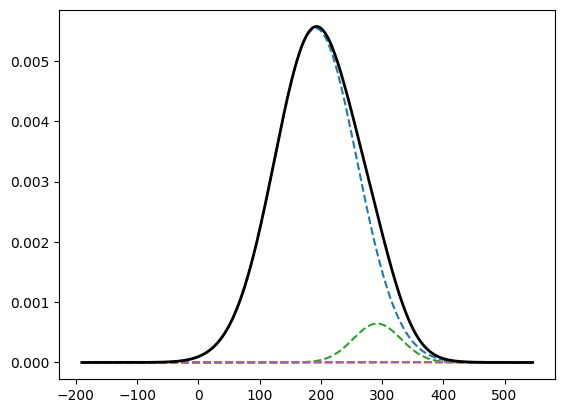

In [89]:
features = player_data.iloc[:, 2:-1]
X_scaled = scaler.transform(features)

model.eval()
with torch.no_grad():
    sample = X_scaled.reshape(1, -1)
    sample_tensor = torch.tensor(sample, dtype=torch.float32).to(device)
    pi, mu, sigma = model(sample_tensor)
    pi = np.array(pi.cpu())
    mu = np.array(mu.cpu())
    sigma = np.array(sigma.cpu())

mu = y_scaler.inverse_transform(mu)
sigma = sigma * y_scaler.scale_[0]

print(f'Mu: {mu}')
print(f'Sigma: {sigma}')
print(f'Pi: {pi}')

x = np.linspace(mu.min() - 3*sigma.max(), mu.max() + 3*sigma.max(), 500)

total = np.zeros_like(x)
for i in range(len(pi[0])):
    component = pi[0][i] * norm.pdf(x, mu[0][i], sigma[0][i])
    plt.plot(x, component, '--')
    total += component

plt.plot(x, total, 'k-', linewidth=2)
plt.show()

Mu: [[191.56712  126.19996  291.84494  344.189     11.338006]]
Sigma: [[67.24551    65.08703    39.06711    55.26125     0.47325665]]
Pi: [[9.3485028e-01 8.7324344e-04 6.3124426e-02 1.1520506e-03 2.7260319e-10]]

Percentiles:
10%: 107.76
25%: 150.32
50%: 197.43
75%: 246.11
90%: 289.41


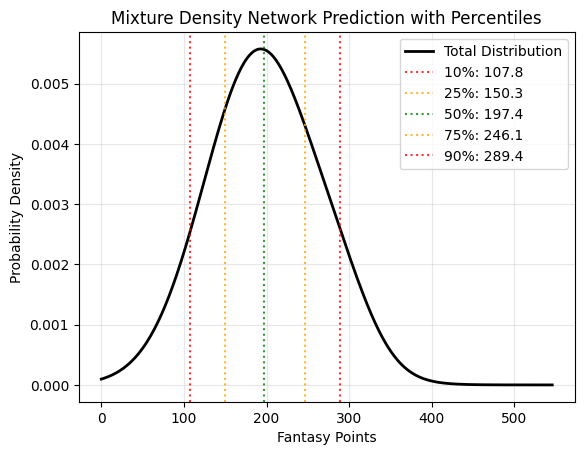

In [90]:
features = player_data.iloc[:, 2:-1]
X_scaled = scaler.transform(features)

model.eval()
with torch.no_grad():
    sample = X_scaled.reshape(1, -1)
    sample_tensor = torch.tensor(sample, dtype=torch.float32).to(device)
    pi, mu, sigma = model(sample_tensor)
    pi = np.array(pi.cpu())
    mu = np.array(mu.cpu())
    sigma = np.array(sigma.cpu())

mu = y_scaler.inverse_transform(mu)
sigma = sigma * y_scaler.scale_[0]

print(f'Mu: {mu}')
print(f'Sigma: {sigma}')
print(f'Pi: {pi}')

# Sample from the mixture distribution to calculate percentiles
def sample_from_mixture(pi, mu, sigma, n_samples=50000):
    samples = []
    
    for _ in range(n_samples):
        # Choose which component to sample from based on pi weights
        component = np.random.choice(len(pi[0]), p=pi[0])
        # Sample from the chosen Gaussian component
        sample = np.random.normal(mu[0][component], sigma[0][component])
        samples.append(sample)
    
    return np.array(samples)

# Generate samples and calculate percentiles
samples = sample_from_mixture(pi, mu, sigma)
percentiles = [10, 25, 50, 75, 90]
percentile_values = np.percentile(samples, percentiles)

print("\nPercentiles:")
for p, val in zip(percentiles, percentile_values):
    print(f"{p}%: {val:.2f}")

# Plot the distribution
x = np.linspace(0, mu.max() + 3*sigma.max(), 500)

total = np.zeros_like(x)
for i in range(len(pi[0])):
    component = pi[0][i] * norm.pdf(x, mu[0][i], sigma[0][i])
    total += component

plt.plot(x, total, 'k-', linewidth=2, label='Total Distribution')

# Add percentile lines
colors = ['red', 'orange', 'green', 'orange', 'red']
for i, (p, val) in enumerate(zip(percentiles, percentile_values)):
    plt.axvline(val, color=colors[i], linestyle=':', alpha=0.8, label=f'{p}%: {val:.1f}')

plt.xlabel('Fantasy Points')
plt.ylabel('Probability Density')
plt.title('Mixture Density Network Prediction with Percentiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()